In [1]:
import numpy as np
from scipy.linalg import eig
import matplotlib.pyplot as plt
import scipy.sparse.linalg as sla
import scipy

def H(size,t1,t2,d,PBC=False,broken_cell = False):


	U = np.array([[0,t1+d],[t1-d,0]])
	Tm = np.array([[0,0],[t2,0]])

	diagonal = np.eye(size)
	off_diagonal_p = np.eye(size, k = 1)
	off_diagonal_m = np.eye(size, k = -1)

	hamiltonian = np.kron(diagonal, U)+ np.kron(off_diagonal_m, Tm.conj().T) + np.kron(off_diagonal_p,Tm) 


	if PBC==True:
		if broken_cell == True:
			print('broken_cell == True requires open system here')
			exit()
		boundary_p = np.eye(size, k = size-1)
		boundary_m = np.eye(size, k = -(size-1))

		boundary_terms = np.kron(boundary_p,Tm.conj().T)+ np.kron(boundary_m,Tm)

		hamiltonian = hamiltonian + boundary_terms

	elif broken_cell == True:
		hop_vec = np.zeros(2*size)
		hop_vec[-1] = np.conj(t2)
		hamiltonian = np.append(hamiltonian,[hop_vec],axis=0)

		hop_vec_T = np.zeros(2*size+1)
		hop_vec_T[-2]= t2
		hamiltonian = np.append(hamiltonian,np.array([hop_vec_T]).T,axis=1)

	return hamiltonian

[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.70710678 0.70710678 0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.        ]


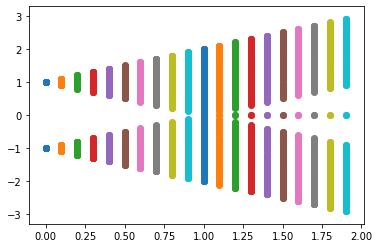

In [2]:
#plot spectrum of the chain
for k in np.arange(0,2,0.1):
	h = H(50,1,k,0,broken_cell=False)

	eigs, eigvec = np.linalg.eigh(h)
	if k==0:
		print(eigvec[:,50])

	plt.scatter(np.ones(eigs.shape)*k,eigs)
plt.show()

In [3]:
# get left and right eigenvectors in the non-Hermitian case

t1=1.0
t2=1.5
d=0.3
size=200

hamiltonian = H(size,t1,t2,d,PBC=True)

eigvals, eigvecL, eigvecR = eig(hamiltonian,left=True,right=True)

norm = np.diag(eigvecL.conj().T @ eigvecR ) 
eigvecR = eigvecR/norm


In [4]:
#postion operator 
x = np.arange(0,size,1)
postition_op = np.array(np.kron( np.diag(x) , np.eye(2)), dtype=complex)

# for broken cell
add_vec = np.zeros((len(postition_op)+1,1))
add_vec[-1] = (size) 
postition_op = np.append(np.append(postition_op,np.zeros((1,len(postition_op))), axis=0), add_vec,axis=1)
print(postition_op.shape)
print(postition_op)

(401, 401)
[[  0.+0.j   0.+0.j   0.+0.j ...   0.+0.j   0.+0.j   0.+0.j]
 [  0.+0.j   0.+0.j   0.+0.j ...   0.+0.j   0.+0.j   0.+0.j]
 [  0.+0.j   0.+0.j   1.+0.j ...   0.+0.j   0.+0.j   0.+0.j]
 ...
 [  0.+0.j   0.+0.j   0.+0.j ... 199.+0.j   0.+0.j   0.+0.j]
 [  0.+0.j   0.+0.j   0.+0.j ...   0.+0.j 199.+0.j   0.+0.j]
 [  0.+0.j   0.+0.j   0.+0.j ...   0.+0.j   0.+0.j 200.+0.j]]


/Users/albertozorzato/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: ComplexWarning: Casting complex values to real discards the imaginary part


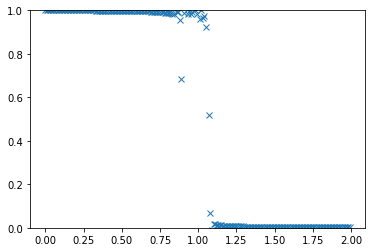

In [7]:
#polarization as function of t1
t_range = np.arange(0,2,0.01)
exp_pos = np.zeros(len(t_range))

for tind,t in enumerate(t_range):
	hamiltonian = H(size,t1,t,d,PBC=False,broken_cell=True)


	eigvals, eigvecL, eigvecR = eig(hamiltonian,left=True,right=True)
	#note: eigvals are sorted in a strange way. uncomment the next line to so whats going on
	#print(eigvals)

	norm = np.diag(eigvecL.conj().T @ eigvecR ) 
	eigvecR = eigvecR/norm
	

	ind = np.nonzero(abs(eigvals) < 1e-5)[0][0]
	exp_pos[tind] = eigvecL[:,ind].conj() @ postition_op @ eigvecR[:,ind]

plt.plot(t_range, exp_pos/size,'x')
plt.ylim([0,1])
plt.show()

/Users/albertozorzato/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


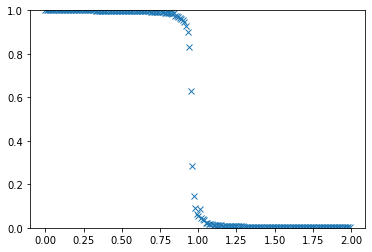

In [6]:
#polarization as function of t1
t_range = np.arange(0,2,0.01)
exp_pos = np.zeros(len(t_range), dtype=complex)





for tind,t in enumerate(t_range):
    hamiltonian = scipy.sparse.csr_matrix(H(size,t1,t,d,PBC=False,broken_cell=True), dtype=complex)
    v0 = np.zeros((2*size + 1,), dtype=complex)
    v0[2*size] = 1

    eigvals, eigvecR = sla.eigs(hamiltonian, k=1, sigma=1e-6, v0=v0)
#     print(eigvals, eigvecR)
    eigvals, eigvecL = sla.eigs(hamiltonian.T.conj(), k=1, sigma=1e-6, v0=v0)
#     print(eigvals, eigvecL)
    #note: eigvals are sorted in a strange way. uncomment the next line to so whats going on
    #print(eigvals)

    norm = np.diag(eigvecL.conj().T @ eigvecR )
#     print('norm = ', norm)
    eigvecR = eigvecR/norm
    

    
#     ind = 0
#     print(ind)
#     print(eigvals, eigvecL.shape, eigvecR.shape)
    exp_pos[tind] = eigvecL[:,ind].conj() @ postition_op @ eigvecR[:,ind]

plt.plot(t_range, exp_pos/size,'x')
plt.ylim([0,1])
plt.show()